# Importing the Libraries

In [1]:
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

2023-10-31 10:35:48.264047: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 10:35:48.970988: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Defining the Constants

In [2]:
IMAGE_SIZE = 128 # image resolution
BATCH_SIZE = 32 # since tensorflow work in batches
CHANNELS = 3 # since it is rgb image
EPOCHS = 80

# Extracting the Data

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "../Dataset/Preprocessed_Alzheimer", shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6400 files belonging to 4 classes.


2023-10-31 10:35:50.282915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 10:35:50.312948: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-31 10:35:50.313410: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [28]:
class_names = dataset.class_names
class_names

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

In [5]:
len(dataset)

200

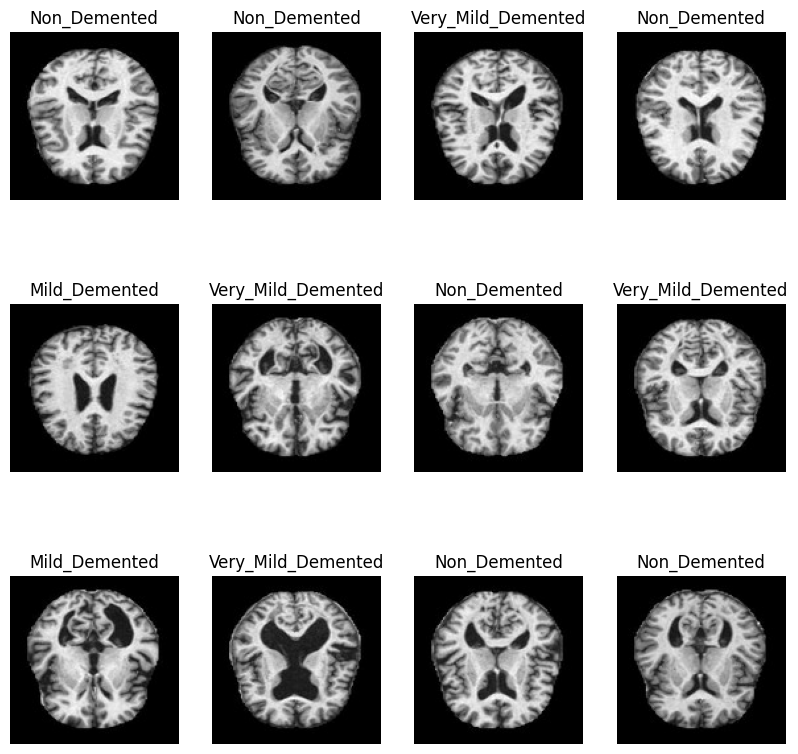

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    # test_size = int(test_split * ds_size)

    train_ds=ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
# dataset=dataset.take(int(len(dataset)/6)) # COMMENT THIS PLEASE IN FINAL TRAINING
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(len(train_ds), len(val_ds), len(test_ds))

160 20 20


# Caching the Data for faster Access

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# this block of code optimises the program by caching.

# Defining the Pre-processing and Data Augmentation Processes

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/(IMAGE_SIZE-1))
])
# preprocessing every time so that slight variations while computing wont occur

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1)
])

# CNN Model Definition

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)), 
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 conv2d_22 (Conv2D)          (32, 126, 126, 32)        896       
                                                                 
 max_pooling2d_22 (MaxPooli  (32, 63, 63, 32)          0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (32, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (32, 30, 30, 64)          0         
 ng2D)                                                

# Compiling and Fitting the Model

In [18]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/80


2023-10-31 10:38:37.974588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-31 10:38:38.959698: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9450a55960 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-31 10:38:38.959739: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2023-10-31 10:38:38.964059: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-31 10:38:39.098202: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


160/160 [==============================] - 10s 28ms/step - loss: 1.0526 - accuracy: 0.4895 - val_loss: 1.0481 - val_accuracy: 0.5188
Epoch 2/80
160/160 [==============================] - 4s 25ms/step - loss: 0.9758 - accuracy: 0.5277 - val_loss: 1.0239 - val_accuracy: 0.5281
Epoch 3/80
160/160 [==============================] - 4s 24ms/step - loss: 0.9489 - accuracy: 0.5469 - val_loss: 0.8936 - val_accuracy: 0.5766
Epoch 4/80
160/160 [==============================] - 4s 24ms/step - loss: 0.9274 - accuracy: 0.5428 - val_loss: 0.9221 - val_accuracy: 0.5625
Epoch 5/80
160/160 [==============================] - 4s 24ms/step - loss: 0.9092 - accuracy: 0.5604 - val_loss: 0.8730 - val_accuracy: 0.5938
Epoch 6/80
160/160 [==============================] - 4s 23ms/step - loss: 0.8909 - accuracy: 0.5613 - val_loss: 0.8830 - val_accuracy: 0.5969
Epoch 7/80
160/160 [==============================] - 4s 23ms/step - loss: 0.8718 - accuracy: 0.5762 - val_loss: 0.8497 - val_accuracy: 0.6156
Epoch 8/8

# Evaluating our Model

In [20]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 1s 8ms/step - loss: 0.1824 - accuracy: 0.9328


In [21]:
history.params

{'verbose': 1, 'epochs': 80, 'steps': 160}

In [22]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Training and Validation Accuracy')

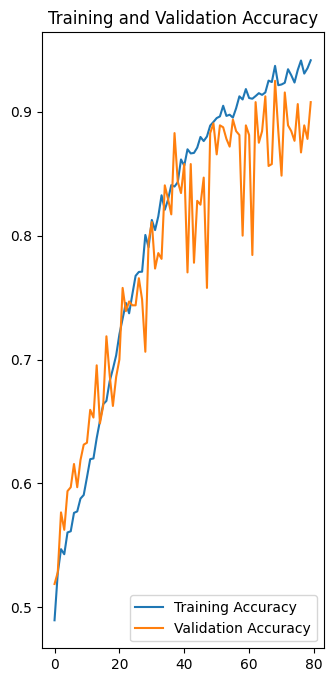

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

In [24]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # create a batch

    predictions = model.predict(img_array, verbose=0)

    predicted_class_number = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_number]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence, predicted_class_number

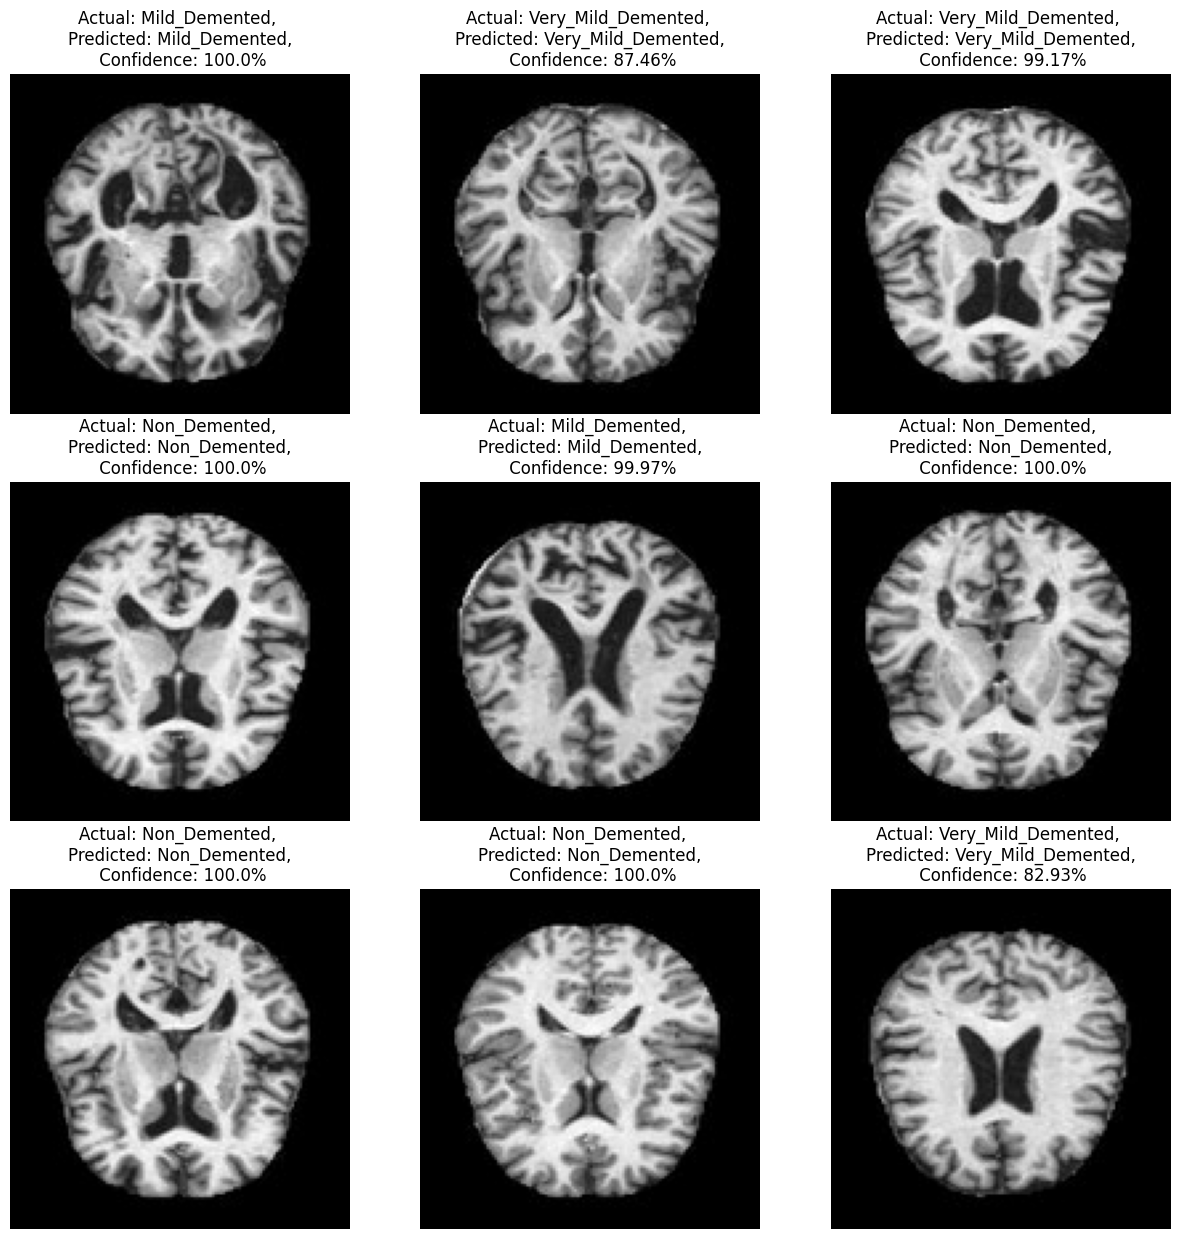

In [25]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence, predicted_class_number = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class},\n Confidence: {confidence}%")
        plt.axis("off")

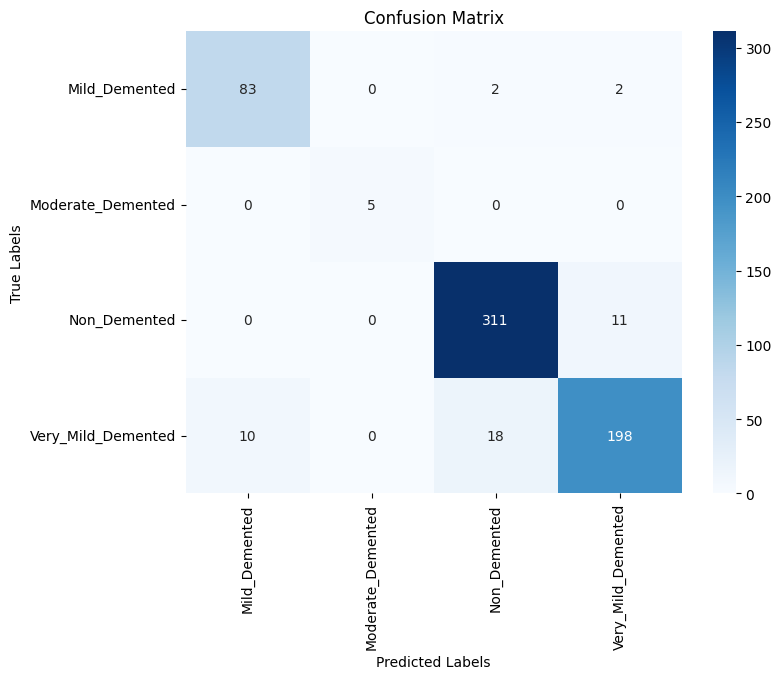

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels=[]
predicted_labels=[]
i=0
for images, labels in test_ds:
    for i in range(len(images)):
        predicted_class, _, predicted_class_number = predict(model, images[i].numpy())
        true_labels.append(labels[i].numpy())
        predicted_labels.append(predicted_class_number)

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Saving the model for Future Use

In [27]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/5/assets


INFO:tensorflow:Assets written to: ../saved_models/5/assets
